In [1]:
pip install rectified-flow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!git clone https://github.com/lqiang67/rectified-flow.git
%cd rectified-flow/

import torch
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

import torch.distributions as dist

from rectified_flow.utils import set_seed
from rectified_flow.utils import visualize_2d_trajectories_plotly

from rectified_flow.rectified_flow import RectifiedFlow

set_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fatal: destination path 'rectified-flow' already exists and is not an empty directory.


C:\Users\57517\Desktop\Diffusion-ToyModel\rectified-flow


# 0. Examples from Codebase.

These are examples of codebase for reference.

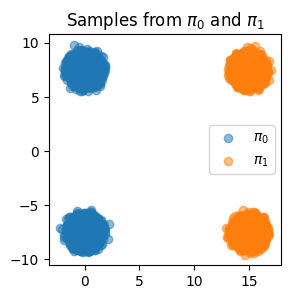

In [3]:
from rectified_flow.datasets.toy_gmm import TwoPointGMM

n_samples = 50000
pi_0 = TwoPointGMM(x=0.0, y=7.5, std=0.5, device=device)
pi_1 = TwoPointGMM(x=15.0, y=7.5, std=0.5, device=device)
D0 = pi_0.sample([n_samples])
D1, labels = pi_1.sample_with_labels([n_samples])
labels.tolist()

plt.figure(figsize=(3, 3))
plt.title(r'Samples from $\pi_0$ and $\pi_1$')
plt.scatter(D0[:, 0].cpu(), D0[:, 1].cpu(), alpha=0.5, label=r'$\pi_0$')
plt.scatter(D1[:, 0].cpu(), D1[:, 1].cpu(), alpha=0.5, label=r'$\pi_1$')
plt.legend()

In [4]:
x_0 = pi_0.sample([500])
x_0_upper = x_0.clone()
x_0_upper[:, 1] = torch.abs(x_0_upper[:, 1])
x_0_lower = x_0.clone()
x_0_lower[:, 1] = -torch.abs(x_0_lower[:, 1])

x_1_upper = pi_1.sample([500])
x_1_lower = pi_1.sample([500])

interp_upper = []
interp_lower = []

for t in np.linspace(0, 1, 100):
    x_t_uppper = (1 - t) * x_0_upper + t * x_1_upper
    x_t_lower = (1 - t) * x_0_lower + t * x_1_lower
    interp_upper.append(x_t_uppper)
    interp_lower.append(x_t_lower)

visualize_2d_trajectories_plotly(
    trajectories_dict={
        "upper": interp_upper,
		"lower": interp_lower
    },
    D1_gt_samples=torch.cat([x_1_upper, x_1_lower], dim=0),
    num_trajectories=100,
	title="Straight Interpolation",
)

In [5]:
from rectified_flow.models.toy_mlp import MLPVelocity

model = MLPVelocity(2, hidden_sizes = [128, 128, 128]).to(device)

rectified_flow = RectifiedFlow(
    data_shape=(2,),
    velocity_field=model,
    interp="straight",
    source_distribution=pi_0,
    device=device,
)

Epoch 0, Loss: 177.8606414794922
Epoch 1000, Loss: 13.419892311096191
Epoch 2000, Loss: 10.179165840148926
Epoch 3000, Loss: 9.962226867675781
Epoch 4000, Loss: 8.102079391479492


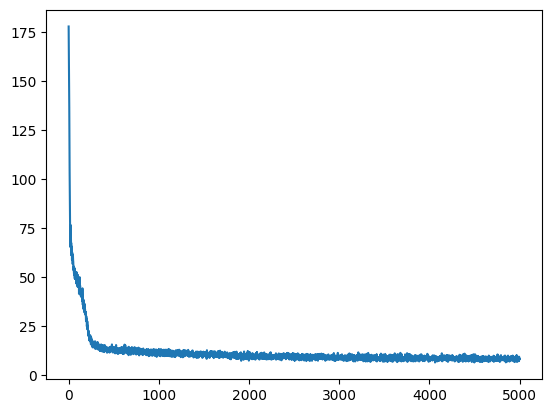

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 1024

losses = []

for step in range(5000):
	optimizer.zero_grad()
	idx = torch.randperm(n_samples)[:batch_size]
	x_0 = D0[idx].to(device)
	x_1 = D1[idx].to(device)

	loss = rectified_flow.get_loss(x_0, x_1)
	loss.backward()
	optimizer.step()
	losses.append(loss.item())

	if step % 1000 == 0:
		print(f"Epoch {step}, Loss: {loss.item()}")

plt.plot(losses)

In [7]:
from rectified_flow.samplers import EulerSampler
from rectified_flow.utils import visualize_2d_trajectories_plotly

euler_sampler_1rf_unconditional = EulerSampler(
    rectified_flow=rectified_flow,
    num_steps=100,
)

traj_upper = euler_sampler_1rf_unconditional.sample_loop(x_0=x_0_upper).trajectories
traj_lower = euler_sampler_1rf_unconditional.sample_loop(x_0=x_0_lower).trajectories

visualize_2d_trajectories_plotly(
    trajectories_dict={"upper": traj_upper, "lower": traj_lower},
    D1_gt_samples=D1[:1000],
    num_trajectories=200,
	title="Unconditional 1-Rectified Flow",
)

# 1. Infrastucture

Here, we build a model to use the code.

This is a 2-d dataset of mixed Gaussian.

In [10]:
N = 10000
dataset = (torch.randint(0,2,(N,1))*2-1)+torch.randn((N,2))*0.2

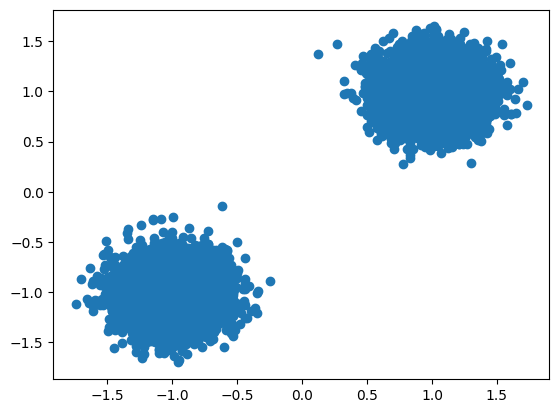

In [11]:
plt.scatter(dataset[:,0],dataset[:,1])

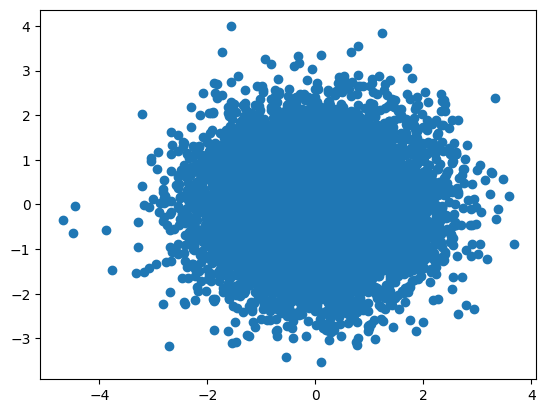

In [12]:
normal = torch.randn((N,2))
plt.scatter(normal[:,0],normal[:,1])

In [13]:
model = MLPVelocity(2, hidden_sizes = [128, 128, 128]).to(device)

rectified_flow = RectifiedFlow(
    data_shape=(2,),
    velocity_field=model,
    interp="straight",
    source_distribution=pi_0,
    device=device,
)

Epoch 0, Loss: 2.1236374378204346
Epoch 1000, Loss: 1.1067705154418945
Epoch 2000, Loss: 0.996195375919342
Epoch 3000, Loss: 1.0204906463623047
Epoch 4000, Loss: 1.0084631443023682


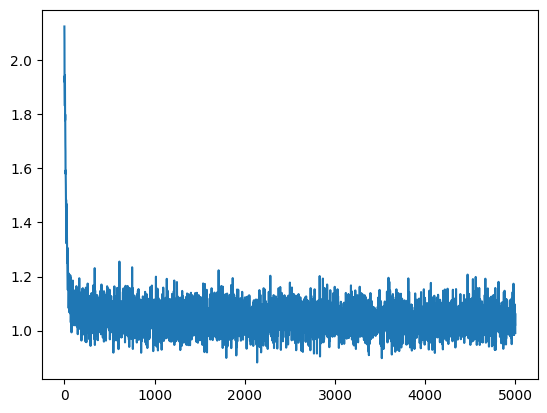

In [14]:
D0 = normal
D1 = dataset

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 1024

losses = []

for step in range(5000):
	optimizer.zero_grad()
	idx = torch.randperm(N)[:batch_size]
	x_0 = D0[idx].to(device)
	x_1 = D1[idx].to(device)

	loss = rectified_flow.get_loss(x_0, x_1)
	loss.backward()
	optimizer.step()
	losses.append(loss.item())

	if step % 1000 == 0:
		print(f"Epoch {step}, Loss: {loss.item()}")

plt.plot(losses)

In [15]:
euler_sampler = EulerSampler(
    rectified_flow=rectified_flow,
    num_steps=100,
)

idx = torch.randperm(N)[:batch_size]
x_0 = D0[idx].to(device)

x_0

tensor([[-0.2494,  1.9867],
        [ 0.0527,  1.1009],
        [ 1.0180, -1.1060],
        ...,
        [-0.7143, -0.8766],
        [ 0.4787,  0.5579],
        [ 0.2590,  0.9593]])

In [16]:
num_samples = 1000
sampled = euler_sampler.sample_loop(seed=0, num_samples=num_samples, x_0=x_0).trajectories[-1]

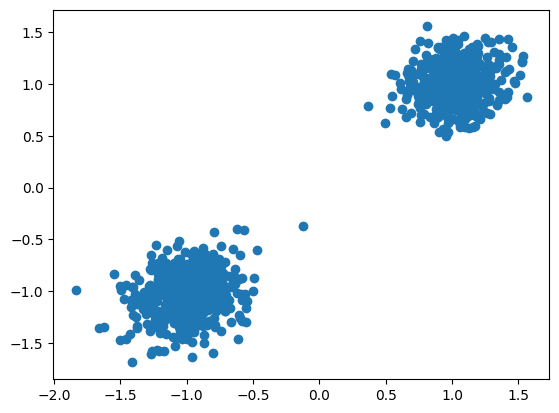

In [17]:
plt.scatter(sampled[:,0],sampled[:,1])

# 2. Calculate the losses

Consider the losses of $t$.

In [18]:
scale = 20
ts = [i/scale for i in range(1,scale)]

In [19]:
for t in ts:
    tensor_t = torch.tensor(t, requires_grad=True) * torch.ones((x_0.size(0),1))
    loss = rectified_flow.get_loss(x_0, x_1, tensor_t)
    print(t, loss)

0.05 tensor(1.1480, grad_fn=<MeanBackward0>)
0.1 tensor(1.2593, grad_fn=<MeanBackward0>)
0.15 tensor(1.3678, grad_fn=<MeanBackward0>)
0.2 tensor(1.4640, grad_fn=<MeanBackward0>)
0.25 tensor(1.5397, grad_fn=<MeanBackward0>)
0.3 tensor(1.5847, grad_fn=<MeanBackward0>)
0.35 tensor(1.5790, grad_fn=<MeanBackward0>)
0.4 tensor(1.5078, grad_fn=<MeanBackward0>)
0.45 tensor(1.3529, grad_fn=<MeanBackward0>)
0.5 tensor(1.1128, grad_fn=<MeanBackward0>)
0.55 tensor(0.8309, grad_fn=<MeanBackward0>)
0.6 tensor(0.6006, grad_fn=<MeanBackward0>)
0.65 tensor(0.4829, grad_fn=<MeanBackward0>)
0.7 tensor(0.4377, grad_fn=<MeanBackward0>)
0.75 tensor(0.5020, grad_fn=<MeanBackward0>)
0.8 tensor(0.6319, grad_fn=<MeanBackward0>)
0.85 tensor(0.8012, grad_fn=<MeanBackward0>)
0.9 tensor(0.9595, grad_fn=<MeanBackward0>)
0.95 tensor(1.0439, grad_fn=<MeanBackward0>)


In [29]:
tensor_t

tensor([[0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        ...,
        [0.0100, 0.0100],
        [0.0100, 0.0100],
        [0.0100, 0.0100]], grad_fn=<MulBackward0>)

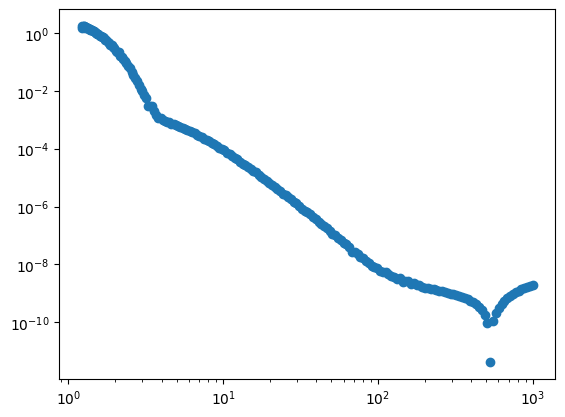

In [ ]:
import matplotlib.pyplot as plt
plt.scatter((1+torch.sqrt(schedule.sigmas)).numpy(), abs(grad.numpy()))
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
loss = torch.tensor([model.get_loss(x0, sigma) for sigma in schedule.sigmas])
loss = loss.detach().squeeze()

/tmp/ipython-input-601804702.py:1: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss = torch.tensor([model.get_loss(x0, sigma) for sigma in schedule.sigmas])


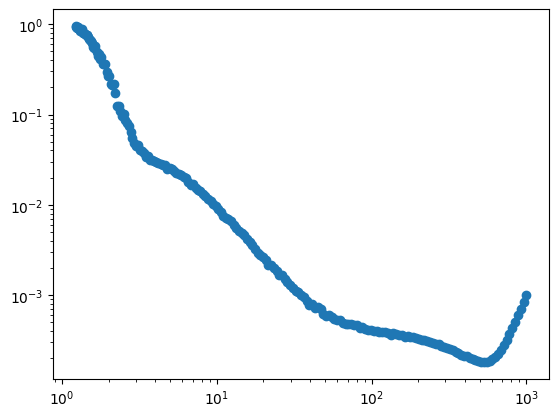

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(((1+torch.sqrt(schedule.sigmas))).numpy(), abs(loss.numpy()))
plt.xscale("log")
plt.yscale("log")
plt.show()

Therefore, we can roughly see that the loss is of scale $1/(1+v_i)$ and also the gradiant of loss is of scale $1/(1+v_1)^2$, which is reasonable.

In [ ]:
# First calculate the loss of dataset or our model
# x0 are the original dataset,
# sigmas are either scalar (all of same noise) or a tensor same as each data in x0.

def get_loss_hi_dim(model: nn.Module,
           x0: torch.FloatTensor,
           sigmas: torch.FloatTensor):
    sigma_grad = sigmas.detach().clone().requires_grad_(True)
    eps = torch.randn_like(x0)
    noise = 1/(1+torch.sqrt(sigma_grad))
    alpha = 1-noise
    x0_hat = model((alpha) * x0 + (noise) * eps, sigma_grad)
    return torch.mean((x0_hat-x0)**2, dim=0)

def get_loss_hi_dim_grad(model: nn.Module,
             x0: torch.FloatTensor,
             sigmas: torch.FloatTensor):
    sigma_grad = sigmas.detach().clone().requires_grad_(True)
    def loss(sigmas):
        eps = torch.randn_like(x0)
        noise = 1/(1+torch.sqrt(sigma_grad))
        alpha = 1-noise
        x0_hat = model((alpha) * x0 + (noise) * eps, sigmas)
        return torch.mean((x0_hat-x0)**2, dim=0)
    return torch.autograd.functional.jacobian(loss, sigma_grad)

Now we test some data.

In [ ]:
sigma_grad = torch.tensor([9.0,99.0], requires_grad=True)

In [ ]:
get_loss_hi_dim_grad(model, x0, sigma_grad)

tensor([[ 1.7676e-05, -2.8157e-06],
        [ 3.7430e-06, -1.2104e-05]])

In [ ]:
get_loss_hi_dim(model, x0, sigma_grad)

tensor([0.0344, 0.0080], grad_fn=<MeanBackward1>)

In [ ]:
M = get_loss_hi_dim_grad(model, x0, sigma_grad)
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[ 0.0025, -0.0036],
        [ 0.0056, -0.1130]], grad_fn=<MulBackward0>)

In [ ]:
# Try another set
sigma_grad = torch.tensor([4.0,9.0], requires_grad=True)
get_loss_hi_dim_grad(model, x0, sigma_grad), get_loss_hi_dim(model, x0, sigma_grad)

(tensor([[ 3.2289e-04, -3.9966e-05],
         [ 6.7867e-05, -1.2135e-04]]),
 tensor([0.0402, 0.0278], grad_fn=<MeanBackward1>))

In [ ]:
M = get_loss_hi_dim_grad(model, x0, sigma_grad)
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[ 0.0062,  0.0015],
        [ 0.0070, -0.0179]], grad_fn=<MulBackward0>)

So aside from the scales of the noises and gradients, we can also observe (roughly) that the Jacobian matrix (gradiant) of the error with respect to the SNR's ($v_i$'s) is roughly diagonal.

What about 3d-data?

In [ ]:
N = 2000           # number of samples
radius = 2.0       # L1 radius |x|_1 = 2
noise_std = 0.1    # sqrt(0.01) -> N(0, 0.01 I)

dirichlet = torch.distributions.Dirichlet(torch.ones(3))
abs_vals = dirichlet.sample((N,))                  # shape: (N, 3), rows sum to 1

signs = torch.randint(0, 2, (N, 3), dtype=torch.float32) * 2 - 1  # in {-1, +1}

x = radius * signs * abs_vals                      # |x|_1 = radius exactly (up to fp roundoff)

dataset_3d = x + noise_std * torch.randn_like(x)

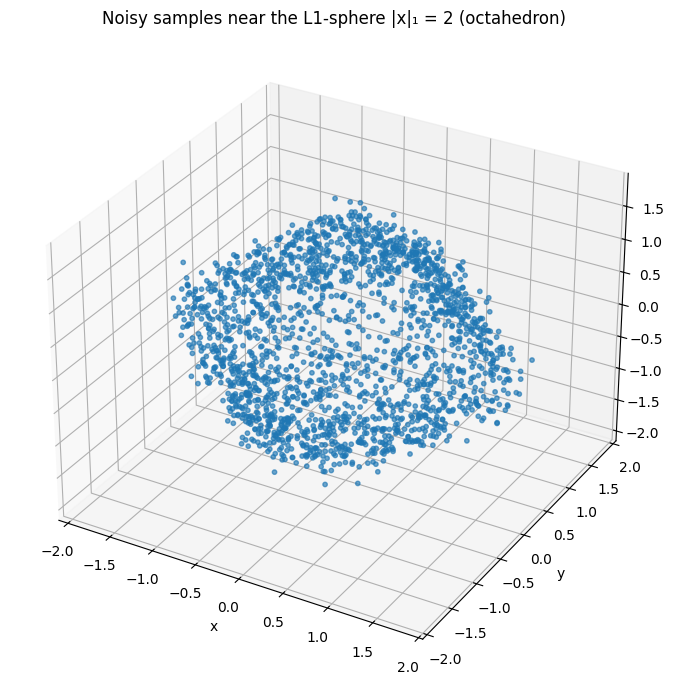

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection in some envs)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_3d[:, 0].numpy(),
           dataset_3d[:, 1].numpy(),
           dataset_3d[:, 2].numpy(),
           s=10, alpha=0.65)

ax.set_title("Noisy samples near the L1-sphere |x|₁ = 2 (octahedron)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Make axes roughly equal-scale
mins = dataset_3d.min(dim=0).values.numpy()
maxs = dataset_3d.max(dim=0).values.numpy()
centers = (mins + maxs) / 2
max_range = (maxs - mins).max() / 2
ax.set_xlim(centers[0] - max_range, centers[0] + max_range)
ax.set_ylim(centers[1] - max_range, centers[1] + max_range)
ax.set_zlim(centers[2] - max_range, centers[2] + max_range)

plt.tight_layout()
plt.show()

100%|██████████| 10000/10000 [06:49<00:00, 24.41it/s]


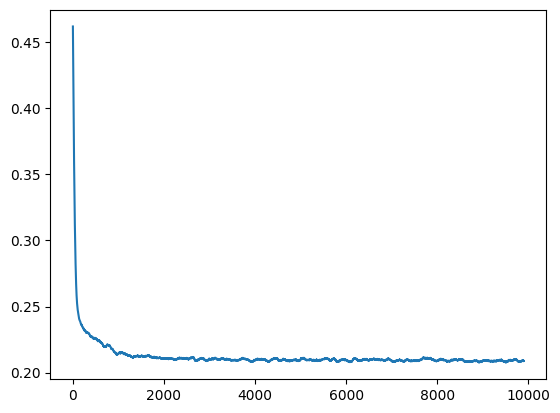

In [ ]:
loader_3d = DataLoader(dataset_3d, batch_size=2048)
model_3d = HighDimNoise(dim = 3, hidden_dims=(16,128,128,128,128,16))
schedule_3d = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=4e4)
trainer_3d = training_loop(loader_3d, model_3d, schedule_3d, epochs=10000, lr=1e-3)
losses_3d = [ns.loss.item() for ns in trainer_3d]
plt.plot(moving_average(losses_3d, 100))
plt.show()

In [ ]:
*xts, x0 = samples(model_3d, schedule_3d.sample_sigmas(20).flip(0), batchsize=1500, gam=1, mu=0)
sigma_grad = torch.tensor([0.1,9.0,999.0], requires_grad=True)
M = get_loss_hi_dim_grad(model_3d, x0, sigma_grad)
M

tensor(0.0100) tensor(0.0199)
tensor(0.0199) tensor(0.0427)
tensor(0.0427) tensor(0.0916)
tensor(0.0916) tensor(0.1967)
tensor(0.1967) tensor(0.4223)
tensor(0.4223) tensor(0.9066)
tensor(0.9066) tensor(1.9461)
tensor(1.9461) tensor(4.1775)
tensor(4.1775) tensor(8.9677)
tensor(8.9677) tensor(19.2505)
tensor(19.2505) tensor(41.3241)
tensor(41.3241) tensor(88.7085)
tensor(88.7085) tensor(190.4264)
tensor(190.4264) tensor(408.7794)
tensor(408.7794) tensor(877.5075)
tensor(877.5075) tensor(1883.7039)
tensor(1883.7039) tensor(4043.6582)
tensor(4043.6582) tensor(8680.3301)
tensor(8680.3301) tensor(18633.6543)
tensor(18633.6543) tensor(39999.9844)


tensor([[ 1.3835e-01, -1.4070e-04,  1.8356e-07],
        [-1.2244e-03, -5.7927e-06, -2.6304e-08],
        [ 8.1835e-04, -1.2462e-06, -9.5735e-08]])

In [ ]:
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[ 1.6740e-01, -1.5477e-03,  2.0192e-04],
        [-1.3468e-02, -5.7927e-04, -2.6304e-04],
        [ 9.0019e-01, -1.2462e-02, -9.5735e-02]], grad_fn=<MulBackward0>)

In [ ]:
*xts, x0 = samples(model_3d, schedule_3d.sample_sigmas(20).flip(0), batchsize=1500, gam=1, mu=0)
sigma_grad = torch.tensor([9.0,99.0,999.0], requires_grad=True)
M = get_loss_hi_dim_grad(model_3d, x0, sigma_grad)
M

tensor(0.0100) tensor(0.0199)
tensor(0.0199) tensor(0.0427)
tensor(0.0427) tensor(0.0916)
tensor(0.0916) tensor(0.1967)
tensor(0.1967) tensor(0.4223)
tensor(0.4223) tensor(0.9066)
tensor(0.9066) tensor(1.9461)
tensor(1.9461) tensor(4.1775)
tensor(4.1775) tensor(8.9677)
tensor(8.9677) tensor(19.2505)
tensor(19.2505) tensor(41.3241)
tensor(41.3241) tensor(88.7085)
tensor(88.7085) tensor(190.4264)
tensor(190.4264) tensor(408.7794)
tensor(408.7794) tensor(877.5075)
tensor(877.5075) tensor(1883.7039)
tensor(1883.7039) tensor(4043.6582)
tensor(4043.6582) tensor(8680.3301)
tensor(8680.3301) tensor(18633.6543)
tensor(18633.6543) tensor(39999.9844)


tensor([[ 6.5679e-04, -6.2208e-06,  4.3975e-07],
        [-1.7495e-05,  4.6775e-07,  2.8995e-08],
        [-7.9064e-09,  1.0695e-06,  1.9935e-07]])

In [ ]:
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[ 6.5679e-02, -6.2208e-03,  4.3975e-03],
        [-1.7495e-02,  4.6775e-03,  2.8995e-03],
        [-7.9064e-05,  1.0695e-01,  1.9935e-01]], grad_fn=<MulBackward0>)

Therefore, we assume that the Jacobian of error $\nabla E(v)$ satiafy $\mathrm{diag}(v)\cdot \nabla E(v) \cdot\mathrm{diag}(v)$ is spectrally bounded.

# 3. Algorithm

We now implement the algorithm. We will use a gradient-based algorithm to do this.

Fisrt, we intialize the schedule as uniform

We now use a different dataset. This is an product measure of triangle distribution and a Gaussian.

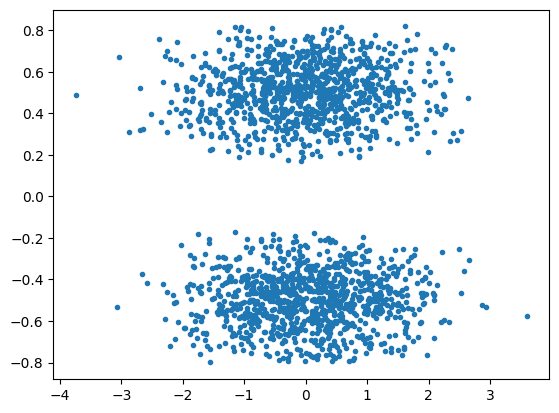

In [ ]:
N = 2000
normal = torch.randn(N)
triangle = (torch.rand(N)-torch.rand(N))/3+torch.randint(0, 2,size = (N,))-0.5
dataset = torch.stack([normal, triangle], 1)
plot_batch(dataset)

Now we train the data

100%|██████████| 15000/15000 [10:07<00:00, 24.69it/s]


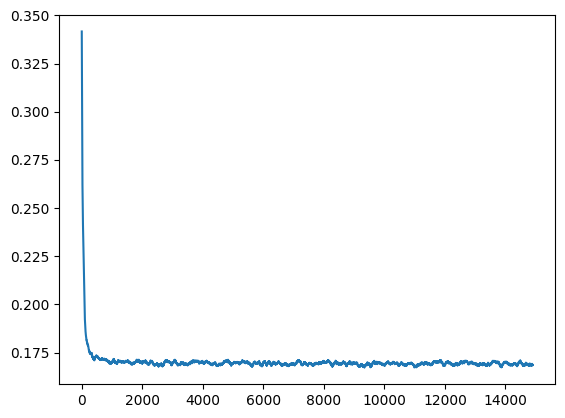

In [ ]:
loader = DataLoader(dataset, batch_size=2048)
model = HighDimNoise(hidden_dims=(16,128,128,128,128,16))
schedule = ScheduleLogLinear(N=100, sigma_min=0.05, sigma_max=1e4)
trainer = training_loop(loader, model, schedule, epochs=15000, lr=1e-3)
losses = [ns.loss.item() for ns in trainer]
plt.plot(moving_average(losses, 100))
plt.show()

Now we calculate the loss and the gradient. Let these schedules (vector!) $v_i$, after taking the gradient, is $(e^{s_i[1]},\dots,e^{s_i[k]})$. The loss is given by the formula:
$$\mathcal E=\sum_{i=1}^{T}\langle E(v_i), v_{i-1}-v_i\rangle=\sum_{i=1}^{T}\langle E(e^{s_i}), e^{s_{i-1}}-e^{s_i}\rangle.$$

Where $E$ is the function form $\mathbb R^n\to\mathbb R^n$

In [ ]:
x0 = dataset
log_sigma = torch.stack([torch.log(schedule.sigmas),torch.log(schedule.sigmas)],1)
log_sigma.requires_grad_(True)
def get_total_loss(model: nn.Module,
                   x0: torch.FloatTensor,
                   log_sigma: torch.FloatTensor):
    assert log_sigma.requires_grad == True
    E = 0
    N = log_sigma.shape[0]
    sigmas = torch.exp(log_sigma)
    # print(sigmas)
    noises = torch.sqrt(1/(1+sigmas))
    alphas = 1-noises
    for i in range(1,N):
        eps = torch.randn_like(x0)
        x0_hat = model((alphas[i]) * x0 + (noises[i]) * eps, sigmas[i])
        Error = torch.mean((x0_hat-x0)**2, dim=0)
        E += torch.dot(Error, sigmas[i]-sigmas[i-1])
    return E

In [ ]:
get_total_loss(model, x0, log_sigma)

tensor(27.5035, grad_fn=<AddBackward0>)

In [ ]:
E=get_total_loss(model, x0, log_sigma)
E.backward()
log_sigma.grad, log_sigma.grad.shape

(tensor([[-5.2594e-02, -1.3731e-02],
         [ 1.0050e-03,  4.7642e-05],
         [-2.1050e-04, -4.6183e-05],
         [ 9.5009e-04,  4.6553e-05],
         [-6.5584e-04, -7.1234e-05],
         [ 1.2026e-03, -5.1062e-04],
         [-3.4287e-03,  4.6077e-04],
         [-6.8631e-04,  4.4419e-04],
         [ 6.4708e-03, -3.9929e-04],
         [-7.1354e-03, -7.4894e-05],
         [ 3.3554e-03,  7.2313e-04],
         [-3.9857e-04, -2.2200e-03],
         [ 6.9584e-04,  4.6520e-04],
         [ 6.8757e-03, -3.1354e-04],
         [-5.6979e-03,  6.6924e-04],
         [-2.6522e-02,  1.8080e-03],
         [ 3.6711e-02, -1.5765e-03],
         [-1.7390e-02, -2.4634e-03],
         [ 1.3434e-02,  3.0025e-03],
         [ 4.8171e-02, -5.0305e-03],
         [-2.8889e-02,  4.0138e-03],
         [-3.3903e-02,  9.4071e-04],
         [ 2.5985e-02,  4.4740e-03],
         [ 1.8313e-02, -5.8818e-03],
         [-6.0307e-02, -1.3500e-02],
         [ 4.7921e-02,  1.4850e-02],
         [-2.0183e-02,  1.0944e-02],
 

We ignore the first and the last one.

In [ ]:
def gradient(model: nn.Module,
             x0: torch.FloatTensor,
             log_sigma: torch.FloatTensor,
             learning_rate: float,
             parity: int,
             grad = None):
    E = get_total_loss(model, x0, log_sigma)
    E.backward()
    if grad is None:
        grad = log_sigma.grad
    n = log_sigma.shape[0]
    if parity == 1:
        index = torch.arange(1, n-1, 2)
    else:
        index = torch.arange(2, n-1, 2)
    updated = log_sigma.detach().clone()
    grad = grad[index]
    norm_grad = torch.clamp(grad.norm(dim=1, keepdim=True), min = 1)
    grad = grad / norm_grad
    clamped_grad = torch.zeros_like(grad)
    diff_prev = log_sigma[index-1] - log_sigma[index]
    diff_next = log_sigma[index+1] - log_sigma[index]

    mask_pos = grad>0
    mask_neg = grad<0

    clamped_grad[mask_pos] = - diff_prev[mask_pos] / grad[mask_pos]
    clamped_grad[mask_neg] = - diff_next[mask_neg] / grad[mask_neg]
    clamped_grad_final = clamped_grad.min(dim = 1).values
    clamped_grad_final = torch.clamp(clamped_grad_final, min=0, max=learning_rate)

    updated[index] = log_sigma[index] - grad*(clamped_grad_final.unsqueeze(1))
    updated = updated.detach().clone()
    updated.requires_grad_(True)
    return updated

Now we try the algorithm!

In [ ]:
x0 = dataset
log_sigma_init = torch.stack([torch.log(schedule.sigmas),torch.log(schedule.sigmas)],1)
log_sigma_init.requires_grad_(True)
loss = [get_total_loss(model, x0, log_sigma_init).item()]
epoch = 200
learning_rate = 0.2

In [ ]:
log_sigma = log_sigma_init.detach().clone()
log_sigma.requires_grad_(True)
for i in range(1,epoch+1):
  if i%10 == 0:
    print(f"{i} / {epoch}")
  log_sigma = gradient(model, x0, log_sigma, learning_rate, i%2)
  loss += [get_total_loss(model, x0, log_sigma).item()]

10 / 200
20 / 200


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
y = loss
x = list(range(epoch+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y)

In [ ]:
final_loss_sigma = log_sigma.detach().clone()
final_loss_sigma, log_sigma_init

Now we compare the generated samples.

In [ ]:
batch_n = 5000

In [ ]:
*xts, x01 = samples(model, torch.exp(log_sigma_init), batchsize=batch_n, gam=1, mu=0)
plot_batch(x01)

In [ ]:
*xts, x02 = samples(model, torch.exp(final_loss_sigma), batchsize=batch_n, gam=1, mu=0)
plot_batch(x02)

In [ ]:
def distance_correlation(data: torch.tensor):

    x = data[:,0].reshape(-1,1)
    y = data[:,1].reshape(-1,1)
    n = x.shape[0]

    a = torch.cdist(x, x, p=2)
    b = torch.cdist(y, y, p=2)

    A = a - a.mean(dim=0, keepdim=True) - a.mean(dim=1, keepdim=True) + a.mean()
    B = b - b.mean(dim=0, keepdim=True) - b.mean(dim=1, keepdim=True) + b.mean()

    dcov2 = (A * B).mean()
    dvarx = (A * A).mean().sqrt()
    dvary = (B * B).mean().sqrt()

    return (dcov2 / (dvarx * dvary)).sqrt()

In [ ]:
# Independent test

distance_correlation(x01), distance_correlation(x02)

In [ ]:
# Distribution test - x

N01 = torch.distributions.Normal(0.0, 1.0)
true_prob = torch.tensor([(i+0.5)/batch_n for i in range(batch_n)])

x1 = x01[:,0]
empirical_p1x = N01.cdf(torch.sort(x1).values)

print(((true_prob-empirical_p1x)**2).sum())
plt.plot(true_prob, empirical_p1x)
plt.show()

In [ ]:
x2 = x02[:,0]
empirical_p2x = N01.cdf(torch.sort(x2).values)

print(((true_prob-empirical_p2x)**2).sum())
plt.plot(true_prob, empirical_p2x)
plt.show()

In [ ]:
# Distribution test - y
def distribution_triangle(x: torch.Tensor) -> torch.Tensor:
    """
    Vectorized CDF corresponding to your scalar distribution_triangle(x),
    for x being a PyTorch tensor (any shape).
    """
    x = x.clone()
    device = x.device
    dtype = x.dtype

    absx = x.abs()

    F_pos = torch.empty_like(absx, dtype=dtype, device=device)

    F_pos.fill_(1.0)

    mask1 = absx <= 1.0/6.0
    F_pos[mask1] = 0.5

    mask2 = (absx > 1.0/6.0) & (absx <= 1.0/2.0)
    F_pos[mask2] = 0.5 + ((absx[mask2] - 1.0/6.0)**2) * 9.0/4.0

    mask3 = (absx > 1.0/2.0) & (absx <= 5.0/6.0)
    F_pos[mask3] = 1.0 - ((5.0/6.0 - absx[mask3])**2) * 9.0/4.0

    F = torch.where(x >= 0, F_pos, 1.0 - F_pos)

    return F

In [ ]:
y1 = x01[:,1]
empirical_p1y = distribution_triangle(torch.sort(y1).values)

print(((true_prob-empirical_p1y)**2).sum())
plt.plot(true_prob, empirical_p1y)
plt.show()

In [ ]:
y2 = x02[:,1]
empirical_p2y = distribution_triangle(torch.sort(y2).values)

print(((true_prob-empirical_p2y)**2).sum())
plt.plot(true_prob, empirical_p2y)
plt.show()

Let's repeat the process

In [ ]:
corrs = []
MSx = []
MSy = []
trial = 20
for i in range(trial):
  if i%5 == 0: print(i)
  *xts, x01 = samples(model, torch.exp(log_sigma_init), batchsize=batch_n, gam=1, mu=0)
  *xts, x02 = samples(model, torch.exp(final_loss_sigma), batchsize=batch_n, gam=1, mu=0)
  corrs.append([distance_correlation(x01), distance_correlation(x02)])

  x1 = x01[:,0]
  empirical_p1x = N01.cdf(torch.sort(x1).values)
  x2 = x02[:,0]
  empirical_p2x = N01.cdf(torch.sort(x2).values)
  MSx.append([((true_prob-empirical_p1x)**2).sum(), ((true_prob-empirical_p2x)**2).sum()])

  y1 = x01[:,1]
  empirical_p1y = distribution_triangle(torch.sort(y1).values)
  y2 = x02[:,1]
  empirical_p2y = distribution_triangle(torch.sort(y2).values)
  MSy.append([((true_prob-empirical_p1y)**2).sum(), ((true_prob-empirical_p2y)**2).sum()])


In [ ]:
trial_range = list(range(1,trial+1))
corr = torch.tensor(corrs)
print(f"mean d-correlation (before,after) {corr.mean(dim = 0)}")
plt.plot(trial_range, corr[:,0], linestyle='-', marker='o', label='initial sigma')
plt.plot(trial_range, corr[:,1], linestyle='-', marker='o', label='final sigma')
plt.xlabel("trials")
plt.ylabel("d-corr")
plt.legend()
plt.show()

In [ ]:
trial_range = list(range(1,trial+1))
msx = torch.tensor(MSx)
print(f"mean square error of P-P plot of x (before,after) {msx.mean(dim = 0)}")
plt.plot(trial_range, msx[:,0], linestyle='-', marker='o', label='initial sigma')
plt.plot(trial_range, msx[:,1], linestyle='-', marker='o', label='final sigma')
plt.xlabel("trials")
plt.ylabel("MSE of P-P plot of x dim")
plt.legend()
plt.show()

In [ ]:
trial_range = list(range(1,trial+1))
msy = torch.tensor(MSy)
print(f"mean square error of P-P plot of y (before,after) {msy.mean(dim = 0)}")
plt.plot(trial_range, msy[:,0], linestyle='-', marker='o', label='initial sigma')
plt.plot(trial_range, msy[:,1], linestyle='-', marker='o', label='final sigma')
plt.xlabel("trials")
plt.ylabel("MSE of P-P plot of y dim")
plt.legend()
plt.show()